# Rossmann sales prediction challenge using fastai2

Content of this notebook is mostly taken from: [data cleaning](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/rossman_data_clean.ipynb) and [modelling notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb) but adjusted where necessary for _fastai2_.

I also added a tool to compare the current model score on the validation set against the public leaderboard on kaggle as well as a modification of the `TabularModel` class to allow other activation functions than ReLu. Added the Mish activation function, which shows quite similar results.

**Steps**
* Extracting data from zip files
* Data processing
    * Loading
    * Sampling
    * Transforming
* Setting up an instance of `TabularDataLoader`
* Training using `TabularModel`
* Training using `RandomForextRegressor`

**Findings**
- `@patch` is awesome
- training a random forest directly on the data used by the deep learning model results in validation scores which are ~2x worse
- I already reached the top ~60-70% of the public leaderboard scores over the entire validation set without much optimizing the tabular learner or the pre-processing steps

In [310]:
%matplotlib inline

In [406]:
from zipfile import ZipFile
from pathlib import Path
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble
from isoweek import Week

In [308]:
dir_raw_data = Path("../data/raw")
dir_leaderboard = Path("../data/leaderboard/")

In [ ]:
# !kaggle competitions download -c rossmann-store-sales -p {dir_raw_data}

In [ ]:
# !kaggle competitions leaderboard rossmann-store-sales -d -p {dir_leaderboard}

## Extracting the data

In [311]:
compressed_data_file = dir_raw_data/"rossmann-store-sales.zip"
compressed_leaderboard_file = dir_leaderboard/"rossmann-store-sales.zip"

In [312]:
def extract_zip_files(fname:Path):
    print(f"Extracting {fname} → {fname.parent}")
    with ZipFile(fname, "r") as f:
        f.extractall(fname.parent)

In [314]:
extract_zip_files(compressed_data_file)

Extracting ../data/raw/rossmann-store-sales.zip → ../data/raw


In [315]:
train_path = dir_raw_data/"train.csv"
test_path = dir_raw_data/"test.csv"
store_path = dir_raw_data/"store.csv"
train_path, test_path, store_path

(Path('../data/raw/train.csv'),
 Path('../data/raw/test.csv'),
 Path('../data/raw/store.csv'))

Additional files used in `rossman_data_clean.ipynb` linking [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

In [516]:
ext_data_dir = Path("../data/rossmann")
ext_files = {
    k: ext_data_dir/f"{k}.csv" for k in ["googletrend", "state_names", "store_states", "weather"]
}
print(ext_files)

{'googletrend': Path('../data/rossmann/googletrend.csv'), 'state_names': Path('../data/rossmann/state_names.csv'), 'store_states': Path('../data/rossmann/store_states.csv'), 'weather': Path('../data/rossmann/weather.csv')}


In [313]:
extract_zip_files(compressed_leaderboard_file)

Extracting ../data/leaderboard/rossmann-store-sales.zip → ../data/leaderboard


In [316]:
fname_leaderboard = dir_leaderboard/"rossmann-store-sales-publicleaderboard.csv"

,TeamId,TeamName,SubmissionDate,Score
17388,222464,SDNT,2015-12-14 23:47:54,0.08932
17035,228972,Gert,2015-12-14 04:12:57,0.08936
17269,232770,NimaShahbazi,2015-12-14 19:27:04,0.09072
17315,239805,SK,2015-12-14 21:52:57,0.09211
17484,239117,Gingerbread Forest,2016-01-17 16:48:54,0.09305


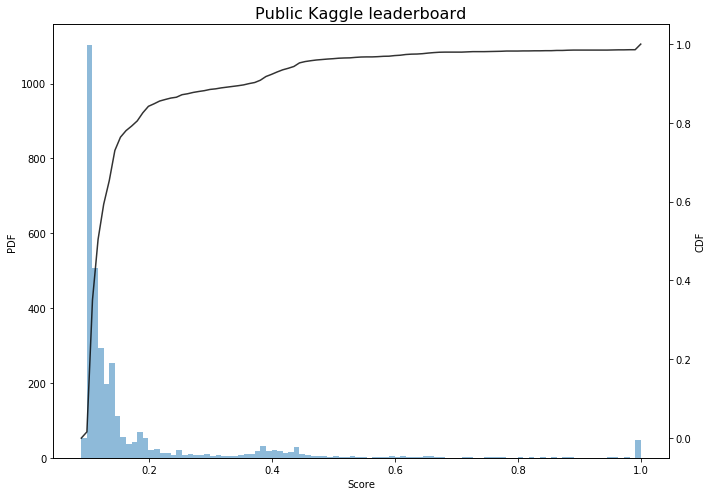

In [456]:
def show_leaderboard(fname:Union[str, Path], score_bounds:tuple=None, col:str="Score", scale:str="linear",
                     score_ascending:bool=True, bins:int=50, my_score:float=None):
    
    df = pd.read_csv(fname, date_parser=["SubmissionDate"])
    if score_bounds is not None:
        assert len(score_bounds) == 2
        if score_bounds[0] is not None:
            df = df.loc[df[col] >= score_bounds[0], :]
        if score_bounds[1] is not None:
            df = df.loc[df[col] <= score_bounds[1], :]
    
    # sorting by score
    df = df.sort_values(col, ascending=score_ascending)
    # removing other entries of the same team
    df = df.drop_duplicates(subset="TeamId")
    
    display(df.head())
    
    
    if scale == "log": bins = np.logspace(np.log(df[col].min()), np.log(df[col].max()), bins)
    h, e = np.histogram(df[col].values, bins=bins, density=True)
    cdf = np.hstack(([0], (h*(e[1:]-e[:-1])).cumsum()))
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.hist(df[col], bins=bins, alpha=.5)
    
    ax1 = ax.twinx()
    ax1.plot(e, cdf, 'k', alpha=.8)
    
    title = f"Public Kaggle leaderboard"
    if my_score is not None:
        my_cdf = np.interp([my_score], e, cdf)
        ax1.scatter([my_score], my_cdf, marker='o', color="r")
        title += f" - my score: {my_score:.2f} = top {my_cdf[0]*100:.2f} %"
    ax1.set_title(title, fontsize=16)
    
    ax.set_xlabel(col)
    ax.set_ylabel("PDF")
    ax.set_xscale(scale)
    ax1.set_ylabel("CDF")
    plt.tight_layout()
    plt.show()
    
show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100)

## Data pipeline

### Loading

**Data field descriptions**: https://www.kaggle.com/c/rossmann-store-sales/data

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [5]:
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_store = pd.read_csv(store_path)

/mnt/e/Programs/anaconda3_wsl/envs/py37_fastai2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
display_all(df.head().T)

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1


In [7]:
display_all(df_test.head().T)

,0,1,2,3,4
Id,1,2,3,4,5
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Date,2015-09-17,2015-09-17,2015-09-17,2015-09-17,2015-09-17
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0


In [8]:
display_all(df_store.head().T)

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN
Promo2SinceYear,NaN,2010,2011,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


In [132]:
df_store.columns.values

array(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype=object)

Loading external files

In [526]:
external_dfs = {
    k: pd.read_csv(_path) for k,_path in ext_files.items()
}
for k in sorted(external_dfs):
    print("\n",k)
    display_all(external_dfs[k].head().T)


 googletrend


,0,1,2,3,4
file,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN
week,2012-12-02 - 2012-12-08,2012-12-09 - 2012-12-15,2012-12-16 - 2012-12-22,2012-12-23 - 2012-12-29,2012-12-30 - 2013-01-05
trend,96,95,91,48,67



 state_names


,0,1,2,3,4
StateName,BadenWuerttemberg,Bayern,Berlin,Brandenburg,Bremen
State,BW,BY,BE,BB,HB



 store_states


,0,1,2,3,4
Store,1,2,3,4,5
State,HE,TH,NW,BE,SN



 weather


,0,1,2,3,4
file,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen
Date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05
Max_TemperatureC,8,7,11,9,8
Mean_TemperatureC,4,4,8,9,8
Min_TemperatureC,2,1,6,8,7
Dew_PointC,7,5,10,9,8
MeanDew_PointC,5,3,8,9,7
Min_DewpointC,1,2,4,8,6
Max_Humidity,94,93,100,100,100
Mean_Humidity,87,85,93,94,94


### Sampling

In [169]:
dep_var = "Sales"

In [253]:
(df[dep_var] == 0).sum()/len(df)

0.16994639253093513

Taking care of zeros

In [254]:
if True:
    print(len(df))
    df = df.loc[(df[dep_var] != 0), :]
    print(len(df))

1017209
844338


Sampling for fast iterations

In [1117]:
small_sample = True
frac = .05
kind = "store"
n_stores = 20  # number of stores to sample if `kind` == "store"

In [1129]:
def do_sample(df):
    if small_sample:
        if kind == "agnostic":
            return df.sample(frac=frac)    

        elif kind == "store":
            stores = np.random.choice(df.Store.unique(), replace=False, size=n_stores)
            return df.loc[df.Store.isin(stores), :].copy(deep=True)
    else:
        return df.copy(deep=True)
    
_df = do_sample(df)

In [1130]:
len(_df)

15292

### Transforming

In [1131]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Processing weather data

In [1132]:
weather = join_df(external_dfs["weather"], external_dfs["state_names"], "file", "StateName")
# make_date(weather, "Date")
weather = add_datepart(weather, "Date", drop=False)
weather.head().T

,0,1,2,3,4
file,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen,NordrheinWestfalen
Date,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00
Max_TemperatureC,8,7,11,9,8
Mean_TemperatureC,4,4,8,9,8
Min_TemperatureC,2,1,6,8,7
Dew_PointC,7,5,10,9,8
MeanDew_PointC,5,3,8,9,7
Min_DewpointC,1,2,4,8,6
Max_Humidity,94,93,100,100,100
Mean_Humidity,87,85,93,94,94


Modifying the googletrend data

In [1133]:
col = "googletrend"

googletrend = external_dfs[col].copy(deep=True)

googletrend["Date"] = googletrend.week.str.split(" - ", expand=True)[0]
googletrend["State"] = googletrend.file.str.split("_", expand=True)[2]
googletrend.loc[googletrend["State"]=="NI", "State"] = "HB,NI"
add_datepart(googletrend, "Date")

display_all(googletrend.head().T)

,0,1,2,3,4
file,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN,Rossmann_DE_SN
week,2012-12-02 - 2012-12-08,2012-12-09 - 2012-12-15,2012-12-16 - 2012-12-22,2012-12-23 - 2012-12-29,2012-12-30 - 2013-01-05
trend,96,95,91,48,67
State,SN,SN,SN,SN,SN
Year,2012,2012,2012,2012,2012
Month,12,12,12,12,12
Week,48,49,50,51,52
Day,2,9,16,23,30
Dayofweek,6,6,6,6,6
Dayofyear,337,344,351,358,365


In [1134]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']
trend_de.head().T

,148,149,150,151,152
file,Rossmann_DE,Rossmann_DE,Rossmann_DE,Rossmann_DE,Rossmann_DE
week,2012-12-02 - 2012-12-08,2012-12-09 - 2012-12-15,2012-12-16 - 2012-12-22,2012-12-23 - 2012-12-29,2012-12-30 - 2013-01-05
trend,77,76,85,59,61
State,None,None,None,None,None
Year,2012,2012,2012,2012,2012
Month,12,12,12,12,12
Week,48,49,50,51,52
Day,2,9,16,23,30
Dayofweek,6,6,6,6,6
Dayofyear,337,344,351,358,365


Modifying train/test data

In [1135]:
%%time
make_date(_df, "Date")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 ms


In [1136]:
_df.sort_values("Date", ascending=True, inplace=True)

In [1137]:
%%time
_df = add_datepart(_df, "Date", drop=False)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 25.7 ms


Making holidays boolean

In [1138]:
if True:
    _df.StateHoliday = _df.StateHoliday != "0"
elif False:
    _df.StateHoliday = _df.StateHoliday.astype(str)

In [1139]:
display_all(_df.head().T)

,1016092,1015029,1015107,1015174,1015183
Store,1113,50,128,195,204
DayOfWeek,3,3,3,3,3
Date,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
Sales,6218,3804,4910,10405,5713
Customers,753,332,446,1322,559
Open,1,1,1,1,1
Promo,0,0,0,0,0
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1
Year,2013,2013,2013,2013,2013


In [1140]:
_df.dtypes

Store                        int64
DayOfWeek                    int64
Date                datetime64[ns]
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                  bool
SchoolHoliday                int64
Year                         int64
Month                        int64
Week                         int64
Day                          int64
Dayofweek                    int64
Dayofyear                    int64
Is_month_end                  bool
Is_month_start                bool
Is_quarter_end                bool
Is_quarter_start              bool
Is_year_end                   bool
Is_year_start                 bool
Elapsed                      int64
dtype: object

In [1141]:
_df[dep_var] = _df[dep_var].astype(float)

Joining tables

In [1142]:
%%time
if True:
    store = join_df(df_store, external_dfs["store_states"], "Store")
    _df = join_df(_df, store, "Store")
    _df = join_df(_df, googletrend, ["State", "Year", "Week"])
    _df = _df.merge(trend_de, "left", ["Year", "Week"], suffixes=("", "_DE"))    
    _df = join_df(_df, weather, ["State","Date"])
    
    # cleaning up duplicate rows indicated by "_y" endings
    for c in _df.columns:
        if c.endswith('_y'):
            if c in _df.columns: _df.drop(c, inplace=True, axis=1)

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 119 ms


In [1143]:
display_all(_df.head().T)

,0,1,2,3,4
Store,1113,50,128,195,204
DayOfWeek,3,3,3,3,3
Date,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
Sales,6218,3804,4910,10405,5713
Customers,753,332,446,1322,559
Open,1,1,1,1,1
Promo,0,0,0,0,0
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1
Year,2013,2013,2013,2013,2013


Processing "Competition*Open" column (contains data on the nearest competitor store, see [data fields](https://www.kaggle.com/c/rossmann-store-sales/data))

In [1144]:
%%time
if True:
    # missing values
    _df['CompetitionOpenSinceYear'] = _df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    _df['CompetitionOpenSinceMonth'] = _df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
        
    # creating a date
    _df["CompetitionOpenSince"] = pd.to_datetime(dict(year=_df.CompetitionOpenSinceYear, 
                                                      month=_df.CompetitionOpenSinceMonth, 
                                                      day=15))
    # total days
    _df["CompetitionDaysOpen"] = _df.Date.subtract(_df.CompetitionOpenSince).dt.days
    # negative days
    _df.loc[_df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    # clipping days
    _df.loc[_df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0
    # adding months as a unit
    _df["CompetitionMonthsOpen"] = _df["CompetitionDaysOpen"]//30
    # capping months
    _df.loc[_df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 20.2 ms


Processing "Promo2*" column (continuing and consecutive promotion)

In [1145]:
%time
if True:
    # missing values
    _df['Promo2SinceYear'] = _df.Promo2SinceYear.fillna(1900).astype(np.int32)
    _df['Promo2SinceWeek'] = _df.Promo2SinceWeek.fillna(1).astype(np.int32)
    # creating a date
    _df["Promo2Since"] = pd.to_datetime(_df.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), 
                                                  axis=1))
    # days since Promo2
    _df["Promo2Days"] = _df.Date.subtract(_df["Promo2Since"]).dt.days
    
    # negative days
    _df.loc[_df.Promo2Days<0, "Promo2Days"] = 0
    # clipping days
    _df.loc[_df.Promo2SinceYear<1990, "Promo2Days"] = 0
    # weeks count
    _df["Promo2Weeks"] = _df["Promo2Days"]//7
    # negative weeks
    _df.loc[_df.Promo2Weeks<0, "Promo2Weeks"] = 0
    # capping weeks
    _df.loc[_df.Promo2Weeks>25, "Promo2Weeks"] = 25

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [1146]:
display_all(_df.head().T)

,0,1,2,3,4
Store,1113,50,128,195,204
DayOfWeek,3,3,3,3,3
Date,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
Sales,6218,3804,4910,10405,5713
Customers,753,332,446,1322,559
Open,1,1,1,1,1
Promo,0,0,0,0,0
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1
Year,2013,2013,2013,2013,2013


Adding fields counting the days before / after promotion, state holiday and school holiday

In [1147]:
joined.loc[:, ["Date","Store"]].sort_values("Date", ascending=False)

,Date,Store
42216,2015-07-31,742
42193,2015-07-31,838
42191,2015-07-31,500
42190,2015-07-31,1050
42189,2015-07-31,973
...,...,...
31,2013-01-02,629
30,2013-01-02,19
29,2013-01-02,1082
28,2013-01-02,896


In [1148]:
def get_elapsed(df, col, prefix):
    # assumes that `df` is sorted by Date and `col` and `df[col]` as readable as boolean
    # calculates the days since `df[col]` was last true for a given store
    day = np.timedelta64(1, 'D')
    prev_date = np.datetime64()  # NaT
    prev_store = 0
    res = np.zeros(len(df))
    
    new_col = f"{prefix}{col}" 
    print("Adding", new_col)

    for i, (store, val, date) in enumerate(zip(df.Store.values, df[col].values, df.Date.values)):
        if store != prev_store:
            prev_date = np.datetime64()  # resets to NaT
            prev_store = store  # updates store
        if val:  # val is boolean or 0/1
            prev_date = date
        res[i] = (date - prev_date).astype('timedelta64[D]') / day
       
    df[new_col] = res

In [1149]:
elapsed_cols = ["Promo", "StateHoliday", "SchoolHoliday"]
tmp_cols = ["Date", "Store"] + elapsed_cols
tmp_df = joined.loc[:, tmp_cols]

In [1150]:
display_all(tmp_df.head().T)

,0,1,2,3,4
Date,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
Store,457,1043,375,207,571
Promo,0,0,0,0,0
StateHoliday,True,True,True,True,True
SchoolHoliday,1,1,1,1,1


In [1151]:
%%time
for col in elapsed_cols:
    print("\nProcessing", col)
    tmp_df = tmp_df.sort_values(["Store", "Date"])
    get_elapsed(tmp_df, col, "After")
    display(tmp_df.head().T)
    tmp_df = tmp_df.sort_values(["Store", "Date"], ascending=[True, False])
    get_elapsed(tmp_df, col, "Before")
    display(tmp_df.head().T)


Processing Promo
Adding AfterPromo


,1778,2417,3053,3370,3785
Date,2013-02-07 00:00:00,2013-02-21 00:00:00,2013-03-06 00:00:00,2013-03-12 00:00:00,2013-03-20 00:00:00
Store,1,1,1,1,1
Promo,1,1,1,0,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,0,0,0,6,0


Adding BeforePromo


,41915,40941,40224,40116,38799
Date,2015-07-25 00:00:00,2015-07-06 00:00:00,2015-06-22 00:00:00,2015-06-19 00:00:00,2015-05-20 00:00:00
Store,1,1,1,1,1
Promo,0,0,0,1,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,36,17,3,0,0
BeforePromo,NaN,NaN,NaN,0,0



Processing StateHoliday
Adding AfterStateHoliday


,1778,2417,3053,3370,3785
Date,2013-02-07 00:00:00,2013-02-21 00:00:00,2013-03-06 00:00:00,2013-03-12 00:00:00,2013-03-20 00:00:00
Store,1,1,1,1,1
Promo,1,1,1,0,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,0,0,0,6,0
BeforePromo,0,0,0,-8,0
AfterStateHoliday,0,0,0,0,0


Adding BeforeStateHoliday


,41915,40941,40224,40116,38799
Date,2015-07-25 00:00:00,2015-07-06 00:00:00,2015-06-22 00:00:00,2015-06-19 00:00:00,2015-05-20 00:00:00
Store,1,1,1,1,1
Promo,0,0,0,1,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,36,17,3,0,0
BeforePromo,NaN,NaN,NaN,0,0
AfterStateHoliday,0,0,0,0,0
BeforeStateHoliday,0,0,0,0,0



Processing SchoolHoliday
Adding AfterSchoolHoliday


,1778,2417,3053,3370,3785
Date,2013-02-07 00:00:00,2013-02-21 00:00:00,2013-03-06 00:00:00,2013-03-12 00:00:00,2013-03-20 00:00:00
Store,1,1,1,1,1
Promo,1,1,1,0,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,0,0,0,6,0
BeforePromo,0,0,0,-8,0
AfterStateHoliday,0,0,0,0,0
BeforeStateHoliday,0,0,0,0,0
AfterSchoolHoliday,NaN,NaN,NaN,NaN,NaN


Adding BeforeSchoolHoliday


,41915,40941,40224,40116,38799
Date,2015-07-25 00:00:00,2015-07-06 00:00:00,2015-06-22 00:00:00,2015-06-19 00:00:00,2015-05-20 00:00:00
Store,1,1,1,1,1
Promo,0,0,0,1,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,36,17,3,0,0
BeforePromo,NaN,NaN,NaN,0,0
AfterStateHoliday,0,0,0,0,0
BeforeStateHoliday,0,0,0,0,0
AfterSchoolHoliday,269,250,236,233,203


CPU times: user 1.92 s, sys: 0 ns, total: 1.92 s
Wall time: 1.92 s


For each of the three fields "Promo", "StateHoliday" and "SchoolHoliday" count for each store how many events were observed using a window size of 7

In [1152]:
tmp_df = tmp_df.set_index("Date")

In [1153]:
%%time
# cleaning up NaNs
for period in ["Before", "After"]:
    for col in elapsed_cols:
        _col = period + col
        tmp_df[_col] = tmp_df[_col].fillna(0).astype(int)
    
display_all(tmp_df.head().T)

Date,2015-07-25,2015-07-06,2015-06-22,2015-06-19,2015-05-20
Store,1,1,1,1,1
Promo,0,0,0,1,1
StateHoliday,True,True,True,True,True
SchoolHoliday,0,0,0,0,0
AfterPromo,36,17,3,0,0
BeforePromo,0,0,0,0,0
AfterStateHoliday,0,0,0,0,0
BeforeStateHoliday,0,0,0,0,0
AfterSchoolHoliday,269,250,236,233,203
BeforeSchoolHoliday,0,0,0,0,0


CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 17.9 ms


In [1154]:
%%time
bwd = tmp_df[['Store'] + elapsed_cols].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
display(bwd.head().T)
bwd.drop('Store', 1, inplace=True)
display(bwd.head().T)
bwd.reset_index(inplace=True)
display(bwd.head().T)

Store                  1                                            
Date          2013-02-07 2013-02-21 2013-03-06 2013-03-12 2013-03-20
Store                1.0        2.0        3.0        4.0        5.0
Promo                1.0        2.0        3.0        3.0        4.0
StateHoliday         1.0        2.0        3.0        4.0        5.0
SchoolHoliday        0.0        0.0        0.0        0.0        0.0

Store                  1                                            
Date          2013-02-07 2013-02-21 2013-03-06 2013-03-12 2013-03-20
Promo                1.0        2.0        3.0        3.0        4.0
StateHoliday         1.0        2.0        3.0        4.0        5.0
SchoolHoliday        0.0        0.0        0.0        0.0        0.0

,0,1,2,3,4
Store,1,1,1,1,1
Date,2013-02-07 00:00:00,2013-02-21 00:00:00,2013-03-06 00:00:00,2013-03-12 00:00:00,2013-03-20 00:00:00
Promo,1,2,3,3,4
StateHoliday,1,2,3,4,5
SchoolHoliday,0,0,0,0,0


CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.34 s


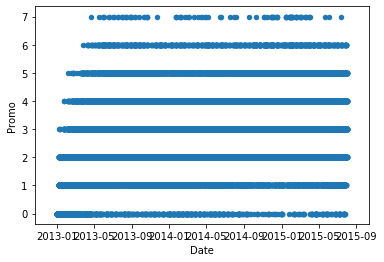

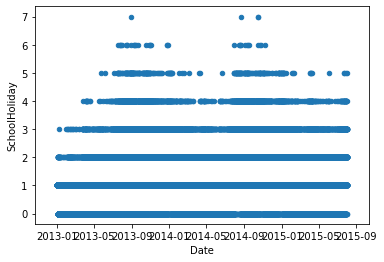

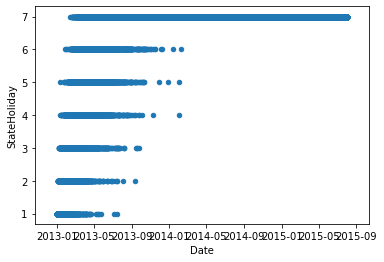

In [1155]:
bwd.plot(kind="scatter", x="Date", y="Promo");
bwd.plot(kind="scatter", x="Date", y="SchoolHoliday");
bwd.plot(kind="scatter", x="Date", y="StateHoliday");

In [1156]:
%%time
fwd = tmp_df[['Store'] + elapsed_cols].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd.drop('Store', 1, inplace=True)
fwd.reset_index(inplace=True)

CPU times: user 2.31 s, sys: 15.6 ms, total: 2.33 s
Wall time: 2.3 s


In [1157]:
tmp_df.reset_index(inplace=True)

Joining the forward and backwards looking windows back in

In [1158]:
tmp_df = tmp_df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
tmp_df = tmp_df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

Pre-emptively remoing `elapsed_cols`

In [1159]:
tmp_df.drop(elapsed_cols, 1, inplace=True)

Tada ...

In [1160]:
display_all(tmp_df.head().T)

,0,1,2,3,4
Date,2015-07-25 00:00:00,2015-07-06 00:00:00,2015-06-22 00:00:00,2015-06-19 00:00:00,2015-05-20 00:00:00
Store,1,1,1,1,1
AfterPromo,36,17,3,0,0
BeforePromo,0,0,0,0,0
AfterStateHoliday,0,0,0,0,0
BeforeStateHoliday,0,0,0,0,0
AfterSchoolHoliday,269,250,236,233,203
BeforeSchoolHoliday,0,0,0,0,0
Promo_bw,2,2,2,2,1
StateHoliday_bw,7,7,7,7,7


Optionally joining in the forward and backward looking stats

In [1161]:
%%time
if True:
    _df = join_df(_df, tmp_df, ["Store", "Date"])

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 40.6 ms


In [1162]:
display_all(_df.head().T)

,0,1,2,3,4
Store,1113,50,128,195,204
DayOfWeek,3,3,3,3,3
Date,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
Sales,6218,3804,4910,10405,5713
Customers,753,332,446,1322,559
Open,1,1,1,1,1
Promo,0,0,0,0,0
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1
Year,2013,2013,2013,2013,2013


## Setting up a `TabularDataLoader`

The variable grouping from the fastai notebook

In [1163]:
cat_names_course = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_names_course = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Custom adjustments to the grouping

In [1164]:
cat_names = [v for v in _df.columns.values if v in cat_names_course]
cont_names = [v for v in _df.columns.values if v in cont_names_course]

# cat_names = ["Store", "DayOfWeek", "Year", "Open", "Promo", "StateHoliday", "SchoolHoliday",
#              "Month", "Week", "Day", "Dayofweek", "Dayofyear"] + [v for v in _df.columns if v.startswith("Is_")]
# cont_names = ["Elapsed", "Sales", "Customers"]

In [1165]:
procs = [Categorify, FillMissing, Normalize]

Setting up the final data set for the modelling, `df_fin`

In [1166]:
df_fin = _df.loc[:, cat_names + cont_names + [dep_var, "Date"]]

Setting up the data split

In [1167]:
df_fin.sort_values("Date", ascending=True, inplace=True)

valid_idx = np.arange(int(.8*len(df_fin)), len(df_fin))
train_idx = np.setdiff1d(np.arange(len(df_fin)), valid_idx)
len(train_idx), len(valid_idx)

(12233, 3059)

In [1168]:
df_fin["Date"][train_idx].min(), df_fin["Date"][train_idx].max()

(Timestamp('2013-01-02 00:00:00'), Timestamp('2015-01-28 00:00:00'))

In [1169]:
df_fin["Date"][valid_idx].min(), df_fin["Date"][valid_idx].max()

(Timestamp('2015-01-28 00:00:00'), Timestamp('2015-07-31 00:00:00'))

Setting up the loader

In [1170]:
to = TabularPandas(df_fin, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=dep_var, splits=IndexSplitter(valid_idx)(df_fin))

In [1171]:
to.xs.head().T

,0,19,18,17,16
Store,20.000000,15.000000,12.000000,13.000000,14.000000
DayOfWeek,3.000000,3.000000,3.000000,3.000000,3.000000
StateHoliday,1.000000,1.000000,1.000000,1.000000,1.000000
Year,1.000000,1.000000,1.000000,1.000000,1.000000
Month,1.000000,1.000000,1.000000,1.000000,1.000000
Week,1.000000,1.000000,1.000000,1.000000,1.000000
Day,2.000000,2.000000,2.000000,2.000000,2.000000
StoreType,1.000000,1.000000,2.000000,3.000000,2.000000
Assortment,2.000000,2.000000,2.000000,2.000000,1.000000
CompetitionOpenSinceYear,1.000000,1.000000,1.000000,9.000000,4.000000


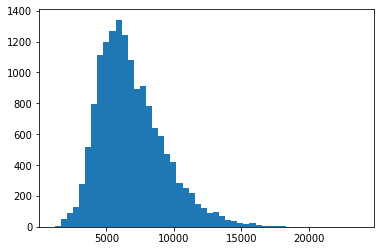

,Sales
0,6218.0
19,6379.0
18,6688.0
17,6303.0
16,4387.0


In [1172]:
fig, ax = plt.subplots()
ax.hist(to.ys[dep_var].values, bins=50)
plt.show()

display(to.ys.head())

In [1173]:
len(to.ys), len(valid_idx), len(_df)

(15292, 3059, 15292)

In [1174]:
%%time
dls = to.dataloaders() # bs=200

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 12.4 ms


## Setting up a `Learner`

In [1175]:
def rmspe_loss(pred:torch.Tensor, target:torch.Tensor):
    return torch.sqrt(((pred-target)/target).pow(2).mean())
    
# loss_fun = torch.nn.functional.mse_loss
loss_fun = rmspe_loss

In [1176]:
y_range = torch.tensor([to.ys[dep_var].values.min(), to.ys[dep_var].values.max()*1.1])
y_range

tensor([ 1174.0000, 26095.3008])

Monkey-patching the `TabularModel` class to use a different activation function because we can

In [1177]:
def mish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(F.softplus(x))

class Mish(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

In [1178]:
@patch
def __init__(self:TabularModel, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
             y_range=None, use_bn=True, bn_final=False, active_fun:nn.Module=None):
    ps = ifnone(ps, [0]*len(layers))
    if not is_listy(ps): ps = [ps]*len(layers)
    self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(embed_p)
    self.bn_cont = nn.BatchNorm1d(n_cont)
    n_emb = sum(e.embedding_dim for e in self.embeds)
    self.n_emb,self.n_cont = n_emb,n_cont
    sizes = [n_emb + n_cont] + layers + [out_sz]
    # actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
    actns = [active_fun() for _ in range(len(sizes)-2)] + [None]
    _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a)
                   for i,(p,a) in enumerate(zip(ps+[0.],actns))]
    if y_range is not None: _layers.append(SigmoidRange(*y_range))
    self.layers = nn.Sequential(*_layers)

In [1179]:
%%time
learn = tabular_learner(dls, n_out=1, loss_func=loss_fun, y_range=y_range, 
                        layers=[200, 100], # [1000, 500] [200, 100]
                        embed_p=.04, # .04
                        ps=[.001, .01], # [.001, .01]
                        metrics=loss_fun,
                        config=dict(active_fun=Mish))

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.7 ms


In [1180]:
learn.summary()

TabularModel (Input shape: ['64 x 38', '64 x 16'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            64 x 9               189        True      
________________________________________________________________
Embedding            64 x 5               35         True      
________________________________________________________________
Embedding            64 x 3               9          True      
________________________________________________________________
Embedding            64 x 3               12         True      
________________________________________________________________
Embedding            64 x 7               91         True      
________________________________________________________________
Embedding            64 x 15              795        True      
________________________________________________________________
Embedding            64 x 11              352        True      
_______________________________________________

In [1181]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(21, 9)
    (1): Embedding(7, 5)
    (2): Embedding(3, 3)
    (3): Embedding(4, 3)
    (4): Embedding(13, 7)
    (5): Embedding(53, 15)
    (6): Embedding(32, 11)
    (7): Embedding(4, 3)
    (8): Embedding(3, 3)
    (9): Embedding(11, 6)
    (10): Embedding(7, 5)
    (11): Embedding(4, 3)
    (12): Embedding(12, 6)
    (13): Embedding(20, 9)
    (14): Embedding(26, 10)
    (15): Embedding(27, 10)
    (16): Embedding(8, 5)
    (17): Embedding(8, 5)
    (18): Embedding(7, 5)
    (19): Embedding(9, 5)
    (20): Embedding(4, 3)
    (21): Embedding(7, 5)
    (22): Embedding(2, 2)
    (23): Embedding(2, 2)
    (24): Embedding(2, 2)
    (25): Embedding(2, 2)
    (26): Embedding(2, 2)
    (27): Embedding(2, 2)
    (28): Embedding(2, 2)
    (29): Embedding(2, 2)
    (30): Embedding(2, 2)
    (31): Embedding(2, 2)
    (32): Embedding(2, 2)
    (33): Embedding(2, 2)
    (34): Embedding(2, 2)
    (35): Embedding(3, 3)
    (36): Embedding(3, 

CPU times: user 15.3 s, sys: 13 s, total: 28.3 s
Wall time: 4.29 s


(3.6307804407442747e-08, 9.12010818865383e-07)

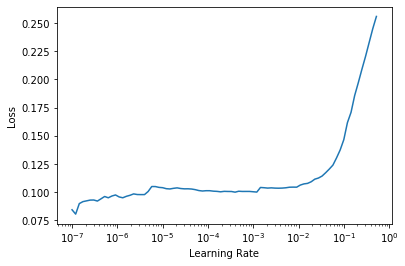

In [1189]:
%%time
learn.lr_find()

In [1190]:
%%time
# learn.fit_one_cycle(5, lr_max=1)
# learn.fit_one_cycle(5, lr_max=5e-1)
# learn.fit_one_cycle(5, lr_max=1e-1)
# learn.fit_one_cycle(5, lr_max=1e-2)
# learn.fit_one_cycle(5, lr_max=5e-3)
# learn.fit_one_cycle(5, lr_max=1e-3)
# learn.fit_one_cycle(5, lr_max=5e-4)
learn.fit_one_cycle(5, lr_max=1e-4)

epoch,train_loss,valid_loss,rmspe_loss,time
0,0.102191,0.126664,0.126664,00:09
1,0.104209,0.124968,0.124968,00:09
2,0.104951,0.125489,0.125489,00:10
3,0.099006,0.126337,0.126337,00:10
4,0.099527,0.124931,0.124931,00:10


CPU times: user 2min 57s, sys: 2min 32s, total: 5min 30s
Wall time: 51.1 s


In [858]:
learn.save("1")

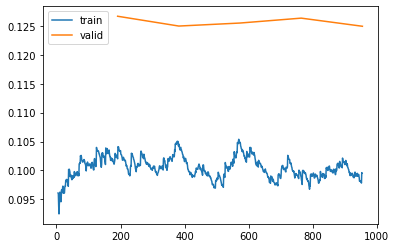

In [1191]:
learn.recorder.plot_loss()

In [1192]:
y_pred, y_true = learn.get_preds()

In [1193]:
y_pred, y_true

(tensor([[ 4328.5137],
         [ 6652.7329],
         [ 6453.9575],
         ...,
         [11330.8545],
         [ 6038.1689],
         [ 5983.5581]]),
 tensor([[ 3855.],
         [ 5916.],
         [ 6106.],
         ...,
         [10760.],
         [ 6621.],
         [ 5729.]]))

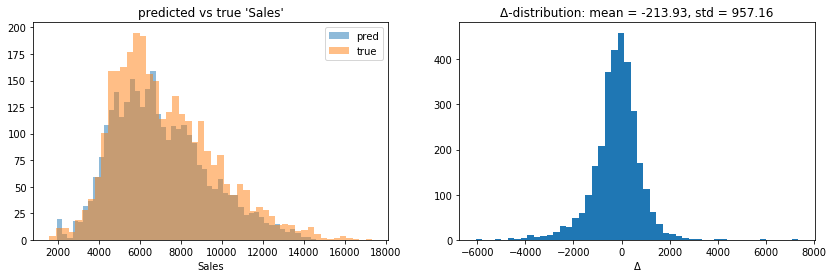

In [1194]:
bins = 50
_y_p = y_pred.detach().numpy().ravel()
_y_t = y_true.detach().numpy().ravel()

fig, axs = plt.subplots(ncols=2, figsize=(14,4))
ax = axs[0]
ax.hist(_y_p, bins=bins, alpha=.5, label="pred")
ax.hist(_y_t, bins=bins, alpha=.5, label="true")
ax.set_xlabel(f"{dep_var}")
ax.set_title(f"predicted vs true '{dep_var}'")
ax.legend()

ax = axs[1]
ax.hist(_y_p-_y_t, bins=bins)
ax.set_xlabel("Δ")
ax.set_title(f"Δ-distribution: mean = {(_y_p-_y_t).mean():.2f}, std = {np.std(_y_p-_y_t):.2f}")
plt.show()

,TeamId,TeamName,SubmissionDate,Score
17388,222464,SDNT,2015-12-14 23:47:54,0.08932
17035,228972,Gert,2015-12-14 04:12:57,0.08936
17269,232770,NimaShahbazi,2015-12-14 19:27:04,0.09072
17315,239805,SK,2015-12-14 21:52:57,0.09211
17484,239117,Gingerbread Forest,2016-01-17 16:48:54,0.09305


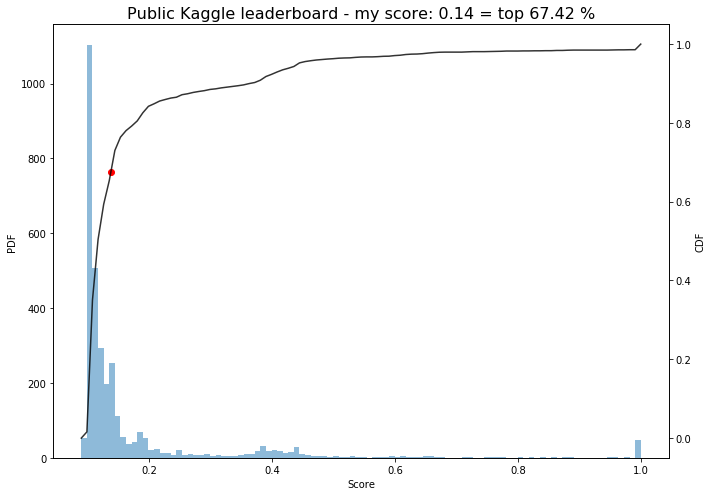

In [1195]:
my_score = rmspe_loss(y_pred, y_true).item()
show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, my_score=my_score)

,TeamId,TeamName,SubmissionDate,Score
17388,222464,SDNT,2015-12-14 23:47:54,0.08932
17035,228972,Gert,2015-12-14 04:12:57,0.08936
17269,232770,NimaShahbazi,2015-12-14 19:27:04,0.09072
17315,239805,SK,2015-12-14 21:52:57,0.09211
17484,239117,Gingerbread Forest,2016-01-17 16:48:54,0.09305


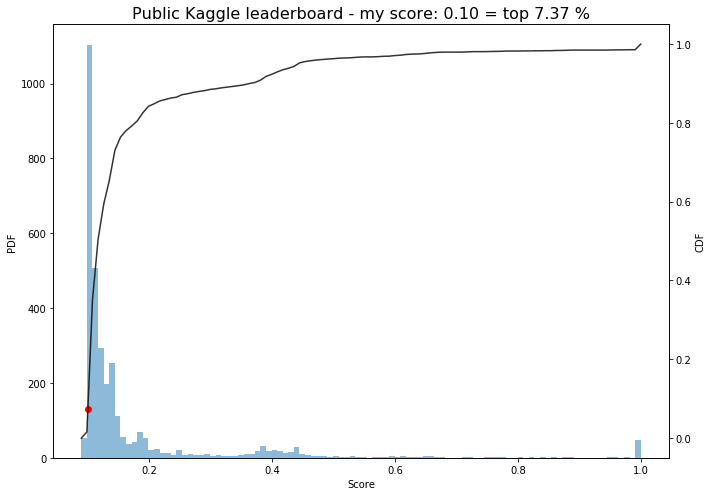

In [486]:
course_score = 0.1
show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, my_score=course_score)

## Same thing but using scikit-learn's ensemble methods

In [1003]:
m = ensemble.RandomForestRegressor(n_estimators=100, max_features="sqrt", max_samples=.75)

In [1004]:
%%time
m.fit(to.xs.iloc[train_idx], to.ys.iloc[train_idx][dep_var].values)

CPU times: user 5.92 s, sys: 62.5 ms, total: 5.98 s
Wall time: 5.98 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.75, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1005]:
X = to.xs.iloc[valid_idx].values
y = torch.from_numpy(to.ys.iloc[valid_idx][dep_var].values)
y_pred = torch.from_numpy(m.predict(X))
my_score = rmspe_loss(y_pred, y).item()

,TeamId,TeamName,SubmissionDate,Score
17388,222464,SDNT,2015-12-14 23:47:54,0.08932
17035,228972,Gert,2015-12-14 04:12:57,0.08936
17269,232770,NimaShahbazi,2015-12-14 19:27:04,0.09072
17315,239805,SK,2015-12-14 21:52:57,0.09211
17484,239117,Gingerbread Forest,2016-01-17 16:48:54,0.09305


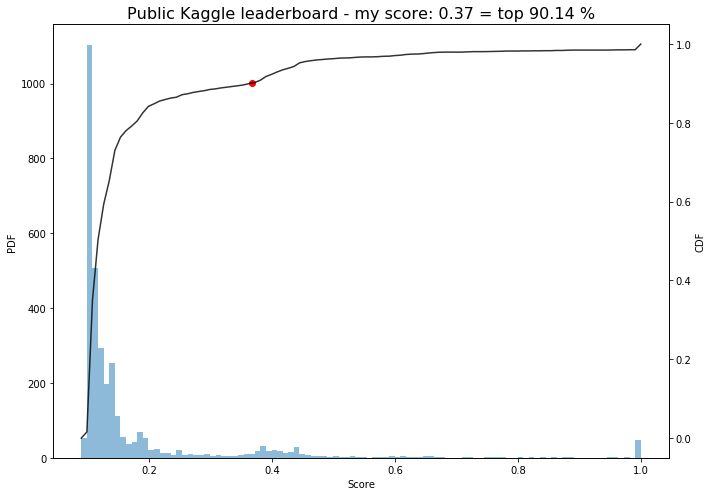

In [1006]:
show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, my_score=my_score)